In [120]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model selection and evaluation
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, f1_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Cross-validation
from sklearn.model_selection import cross_val_score

# Feature importance (for tree-based models)
from sklearn.inspection import permutation_importance

# Saving models
import joblib


In [111]:
# Load data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Overview of the data
print(train_data.head())
print(test_data.head())

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez  


In [112]:
# Drop unnecessary columns
columns_to_drop = ["Destination", "VIP","Name"]
train_data_cleaned = train_data.drop(columns=columns_to_drop)
test_data_cleaned = test_data.drop(columns=columns_to_drop)


In [113]:
print(train_data_cleaned.head())
print(test_data_cleaned.head())

   CryoSleep       Age  Transported GroupID  Amenities  DeckRank  SideRank  \
0          0  0.709437            0    0001          0         9       1.0   
1          0 -0.336717            1    0002          1         4       2.0   
2          0  2.034566            0    0003          1         6       2.0   
3          0  0.290975            0    0003          1         6       2.0   
4          0 -0.894666            1    0004          1         4       2.0   

   HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  
0                 0                  1                0  
1                 1                  0                0  
2                 0                  1                0  
3                 0                  1                0  
4                 1                  0                0  
  PassengerId HomePlanet CryoSleep  Cabin   Age  RoomService  FoodCourt  \
0     0013_01      Earth      True  G/3/S  27.0          0.0        0.0   
1     0018_01      Earth     Fals

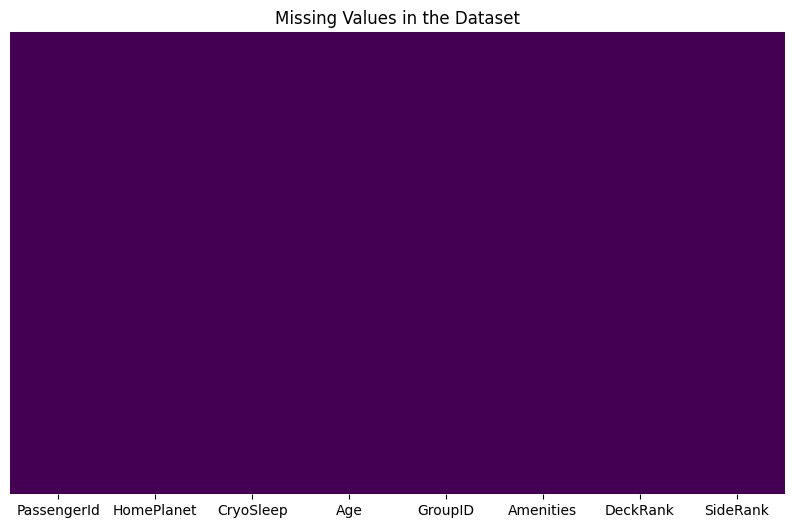

In [157]:
# Combine train and test data for visualization purposes
combined_data = pd.concat([test_data_cleaned], axis=0, ignore_index=True)

# Plot missing values
plt.figure(figsize=(10, 6))
sns.heatmap(combined_data.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Missing Values in the Dataset")
plt.show()

Handling Missing Values

In [126]:

# Fill missing values in 'Age' with the mean
mean_age = train_data_cleaned['Age'].mean()
train_data_cleaned['Age'].fillna(mean_age, inplace=True)

mean_age = test_data_cleaned['Age'].mean()
test_data_cleaned['Age'].fillna(mean_age, inplace=True)

# Fill missing values in 'HomePlanet' with the mode (Earth)
test_data_cleaned['HomePlanet'].fillna('Earth', inplace=True)
train_data_cleaned['HomePlanet'].fillna('Earth', inplace=True)


In [128]:
# Define a function to impute CryoSleep based on amenities usage
def impute_cryosleep(row):
    # Check if any of the amenities have a spending greater than 0
    if row[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum() == 0:
        return True  # No spending, likely in CryoSleep
    else:
        return False  # Spent money, likely not in CryoSleep

# Apply the function to handle missing CryoSleep values
train_data_cleaned['CryoSleep'] = train_data_cleaned.apply(
    lambda row: impute_cryosleep(row) if pd.isnull(row['CryoSleep']) else row['CryoSleep'], axis=1
)

In [130]:
# Extract GroupID from PassengerId
#train_data_cleaned['GroupID'] = train_data_cleaned['PassengerId'].str.split('_').str[0]

print(train_data_cleaned['GroupID'].head())


0    0013
1    0018
2    0019
3    0021
4    0023
Name: GroupID, dtype: object


In [52]:
#Drop 'PassengerId' and keep 'GroupID' for modeling purposes
#train_data_cleaned.drop('PassengerId', axis=1, inplace=True)

In [131]:
# For missing 'Cabin', assign the same cabin as another passenger in the same group or a default value if no cabins are available
def impute_cabin(row):
    if pd.isnull(row['Cabin']):
        group_id = row['GroupID']
        # Get non-null cabins for the same group
        group_cabin_values = train_data_cleaned[train_data_cleaned['GroupID'] == group_id]['Cabin'].dropna()
        
        if not group_cabin_values.empty:
            # If there are non-null cabins, assign the first one
            return group_cabin_values.iloc[0]
        else:
            # If there are no non-null cabins in the group, assign 'Unknown'
            return 'Unknown'
    else:
        return row['Cabin']

# Apply the function to handle missing 'Cabin' values
train_data_cleaned['Cabin'] = train_data_cleaned.apply(impute_cabin, axis=1)


In [135]:
# Set values for amenities to 0 for passengers in CryoSleep
train_data_cleaned.loc[train_data_cleaned['CryoSleep'] == True, 
                       ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = 0

In [142]:
# Combine the 5 amenities columns into one binary column 'Amenities'
train_data_cleaned['Amenities'] = train_data_cleaned[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].apply(
    lambda row: 1 if (row > 0).any() else 0, axis=1)


In [144]:
# Drop the original amenity columns
train_data_cleaned.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1, inplace=True)

In [165]:
print(test_data_cleaned.head(20))

   PassengerId  CryoSleep       Age  Amenities  DeckRank  SideRank  \
0      0013_01          1 -0.118222          0         9       1.0   
1      0018_01          0 -0.688601          1         4       2.0   
2      0019_01          1  0.166968          0         6       2.0   
3      0021_01          0  0.666051          1         6       2.0   
4      0023_01          0 -0.617304          1         4       2.0   
5      0027_01          0  0.166968          1         4       1.0   
6      0029_01          1 -0.546006          0         4       2.0   
7      0032_01          1 -0.617304          0         7       2.0   
8      0032_02          1 -0.403411          0         4       2.0   
9      0033_01          0 -0.332114          0         9       1.0   
10     0037_01          0 -0.688601          0         9       1.0   
11     0040_01          0  1.165133          1         9       1.0   
12     0040_02          0  1.093835          1         4       1.0   
13     0042_01      

In [148]:
# Convert 'CryoSleep' and 'Transported' columns to numeric (1 and 0)
train_data_cleaned['CryoSleep'] = train_data_cleaned['CryoSleep'].astype(int)
train_data_cleaned['Transported'] = train_data_cleaned['Transported'].astype(int)


In [150]:
# Split 'Cabin' into 'Deck' and 'Side'
train_data_cleaned['Deck'] = train_data_cleaned['Cabin'].str.split('/').str[0]  # Extract deck
train_data_cleaned['Side'] = train_data_cleaned['Cabin'].str.split('/').str[2]  # Extract side

# Drop the original 'Cabin' column
train_data_cleaned.drop(columns=['Cabin'], inplace=True)

In [152]:
# Calculate danger ranking for Deck based on Transported rate
deck_danger = train_data_cleaned.groupby('Deck')['Transported'].mean().sort_values(ascending=True).reset_index()

# Assign ranks (1 is most dangerous, higher numbers are safer)
deck_danger['DangerRank'] = range(1, len(deck_danger) + 1)

# Map the danger rank back to the Deck column
deck_rank_map = dict(zip(deck_danger['Deck'], deck_danger['DangerRank']))

# Apply the rank mapping to the DeckRank column
train_data_cleaned['DeckRank'] = train_data_cleaned['Deck'].map(deck_rank_map)


KeyError: 'Column not found: Transported'

In [153]:
# Fill missing features or create approximations if necessary
test_data_cleaned['DeckRank'] = train_data_cleaned['DeckRank']
test_data_cleaned['SideRank'] = train_data_cleaned['SideRank']


In [88]:
# Calculate danger ranking for Side based on Transported rate
side_danger = train_data_cleaned.groupby('Side')['Transported'].mean().sort_values(ascending=True).reset_index()

# Assign ranks (1 is safest, higher numbers are more dangerous)
side_danger['DangerRank'] = range(1, len(side_danger) + 1)

# Map the danger rank back to the Side column
side_rank_map = dict(zip(side_danger['Side'], side_danger['DangerRank']))

# Apply the rank mapping to the SideRank column
train_data_cleaned['SideRank'] = train_data_cleaned['Side'].map(side_rank_map)


In [91]:
# Fill missing values (NaNs) in SideRank with the mode (most frequent value)
side_mode = train_data_cleaned['SideRank'].mode()[0]
train_data_cleaned['SideRank'].fillna(side_mode, inplace=True)


In [166]:
#test_data_cleaned.drop(columns=['GroupID'], inplace=True)

In [100]:
print(train_data_cleaned['HomePlanet'].unique())

['Earth' 'Europa' 'Mars']


In [161]:
# One-hot encode the 'HomePlanet' column
train_data_cleaned = pd.get_dummies(train_data_cleaned, columns=['HomePlanet'], prefix=['HomePlanet'])

In [162]:
# Convert boolean to integer (1 for True, 0 for False)
train_data_cleaned['HomePlanet_Mars'] = train_data_cleaned['HomePlanet_Mars'].astype(int)
train_data_cleaned['HomePlanet_Earth'] = train_data_cleaned['HomePlanet_Earth'].astype(int)
train_data_cleaned['HomePlanet_Europa'] = train_data_cleaned['HomePlanet_Europa'].astype(int)


In [164]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the Age column
test_data_cleaned['Age'] = scaler.fit_transform(test_data_cleaned[['Age']])

In [167]:
print(train_data_cleaned.head())

   CryoSleep       Age  Transported  Amenities  DeckRank  SideRank  \
0          0  0.709437            0          0         9       1.0   
1          0 -0.336717            1          1         4       2.0   
2          0  2.034566            0          1         6       2.0   
3          0  0.290975            0          1         6       2.0   
4          0 -0.894666            1          1         4       2.0   

   HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  
0                 0                  1                0  
1                 1                  0                0  
2                 0                  1                0  
3                 0                  1                0  
4                 1                  0                0  


Training

In [116]:

# Split the data into features (X) and target (y)
X = train_data_cleaned.drop(columns=['Transported', 'GroupID'])  # Drop the target and 'GroupID' for now
y = train_data_cleaned['Transported']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on validation set
y_pred = rf_model.predict(X_val)

# Evaluate the model
print("Accuracy:", accuracy_score(y_val, y_pred))
print("AUC-ROC:", roc_auc_score(y_val, y_pred))
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Feature Importance (to understand the influence of GroupID and Amenities)
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df)


Accuracy: 0.7061529614721104
AUC-ROC: 0.7065690157389696
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       861
           1       0.73      0.66      0.70       878

    accuracy                           0.71      1739
   macro avg       0.71      0.71      0.71      1739
weighted avg       0.71      0.71      0.71      1739

Feature Importances:
             Feature  Importance
1                Age    0.397749
2          Amenities    0.233595
0          CryoSleep    0.180527
3           DeckRank    0.097162
5   HomePlanet_Earth    0.031830
4           SideRank    0.029444
6  HomePlanet_Europa    0.019300
7    HomePlanet_Mars    0.010393


C:\Users\AWAIS\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [18:47:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7268545140885566
AUC-ROC: 0.7962929157439963
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       861
           1       0.77      0.66      0.71       878

    accuracy                           0.73      1739
   macro avg       0.73      0.73      0.73      1739
weighted avg       0.73      0.73      0.73      1739

Feature Importances:
             Feature  Importance
2          Amenities    0.820436
5   HomePlanet_Earth    0.084939
0          CryoSleep    0.026700
6  HomePlanet_Europa    0.018119
3           DeckRank    0.017314
4           SideRank    0.014183
7    HomePlanet_Mars    0.010376
1                Age    0.007933


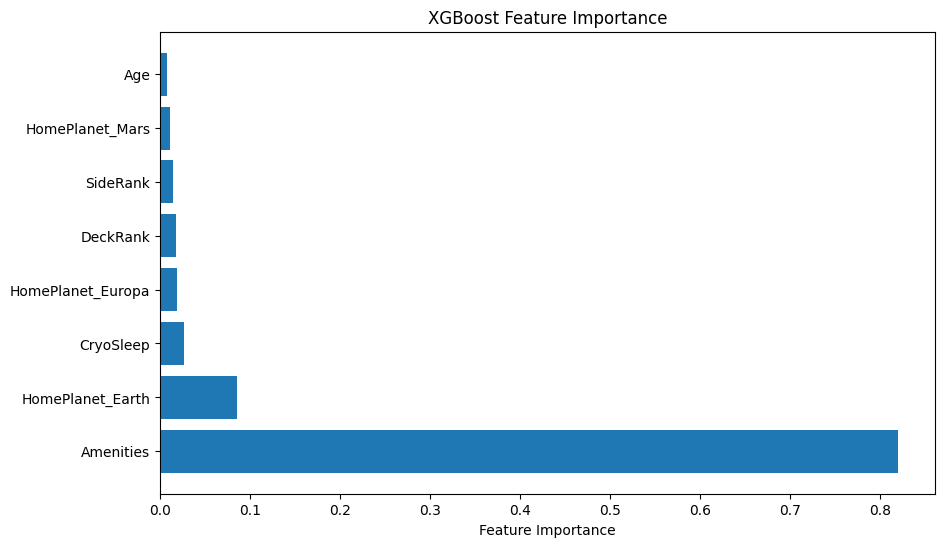

In [169]:
# Split the data into features (X) and target (y)
X = train_data_cleaned.drop(columns=['Transported'])  # Drop target
y = train_data_cleaned['Transported']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability for ROC-AUC

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
class_report = classification_report(y_test, y_pred)

# Feature importance
feature_importances = model.feature_importances_

# Output the results
print(f"Accuracy: {accuracy}")
print(f"AUC-ROC: {roc_auc}")
print("Classification Report:")
print(class_report)


feat_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feat_importance_df)

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()

In [170]:
# Make predictions on the test set
y_test_pred = model.predict(test_data_cleaned.drop(columns=['PassengerId']))

# Create the submission DataFrame
submission = pd.DataFrame({
    'PassengerId': test_data_cleaned['PassengerId'],
    'Transported': y_test_pred
})

# Save to CSV
submission.to_csv('submission8.csv', index=False)

print("Submission file created: submission8.csv")

Submission file created: submission8.csv


In [177]:
print(submission['Transported'].nunique())

2


In [178]:
# Load the submission file
submission = pd.read_csv('submission8.csv')

# Convert 'Transported' column from 0/1 to boolean (True/False)
submission['Transported'] = submission['Transported'].astype(bool)

# Check the result
print(submission.head())

# Save the modified submission file
submission.to_csv('submission8_updated.csv', index=False)

  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01        False
4     0023_01        False
